### Import Libraries

In [10]:
import pandas as pd
import numpy as np
import psycopg2
import os
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
import requests
import zipfile
import shutil

### Downloading the data to be analyzed

In [3]:
conn = psycopg2.connect(
    host="zip_data_postgres_db",
    database=os.environ.get('POSTGRES_DB'),
    user=os.environ.get('POSTGRES_USER'),
    password=os.environ.get('POSTGRES_PASSWORD')
)

query = "SELECT * FROM reporting_results2020"
df = pd.read_sql_query(query, conn)

/tmp/ipykernel_393/2587181120.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


### Displaying a sample of downloaded data

In [4]:
df.head()

,id,numer_ewidencyjny_system,numer_ewidencyjny_urzad,data_wplywu_wniosku_do_urzedu,nazwa_organu,wojewodztwo_objekt,obiekt_kod_pocztowy,miasto,terc,cecha,...,kubatura,stan,jednostki_numer,obreb_numer,numer_dzialki,numer_arkusza_dzialki,nazwisko_projektanta,imie_projektanta,projektant_numer_uprawnien,projektant_pozostali
0,1,ST-SL-BI/ZGŁOSZENIE/1432/2020,Wb.6743.3.107.2020.KaM,2020-06-04 00:00:00,Starosta Powiatu Bielsko-Biała,śląskie,43-518,Ligota,2402045,,...,,Brak sprzeciwu,240204_5,0005,2395/8,,Świder,Katarzyna,SLK/4131/PWOS/12,
1,2,ST-SL-BI/ZGŁOSZENIE/1432/2020,Wb.6743.3.107.2020.KaM,2020-06-04 00:00:00,Starosta Powiatu Bielsko-Biała,śląskie,43-518,Ligota,2402045,,...,,Brak sprzeciwu,240204_5,0005,2395/5,,Świder,Katarzyna,SLK/4131/PWOS/12,
2,3,ST-SL-RB/ZGŁOSZENIE/6774/2021,AB.6743.915.2021,2021-11-26 00:00:00,Starosta Powiatu Rybnik,śląskie,44-238,Przegędza,2412015,ul.,...,,Brak sprzeciwu,241201_5,0004,1389/6,,Towarek,Grzegorz,SLK/2409/ZOOS/08,
3,4,ST-SL-RB/ZGŁOSZENIE/6774/2021,AB.6743.915.2021,2021-11-26 00:00:00,Starosta Powiatu Rybnik,śląskie,44-238,Przegędza,2412015,ul.,...,,Brak sprzeciwu,241201_5,0004,1727/10,,Towarek,Grzegorz,SLK/2409/ZOOS/08,
4,5,ST-SL-RB/ZGŁOSZENIE/6774/2021,AB.6743.915.2021,2021-11-26 00:00:00,Starosta Powiatu Rybnik,śląskie,44-238,Przegędza,2412015,ul.,...,,Brak sprzeciwu,241201_5,0004,1850/10,,Towarek,Grzegorz,SLK/2409/ZOOS/08,


### Categories of building permits

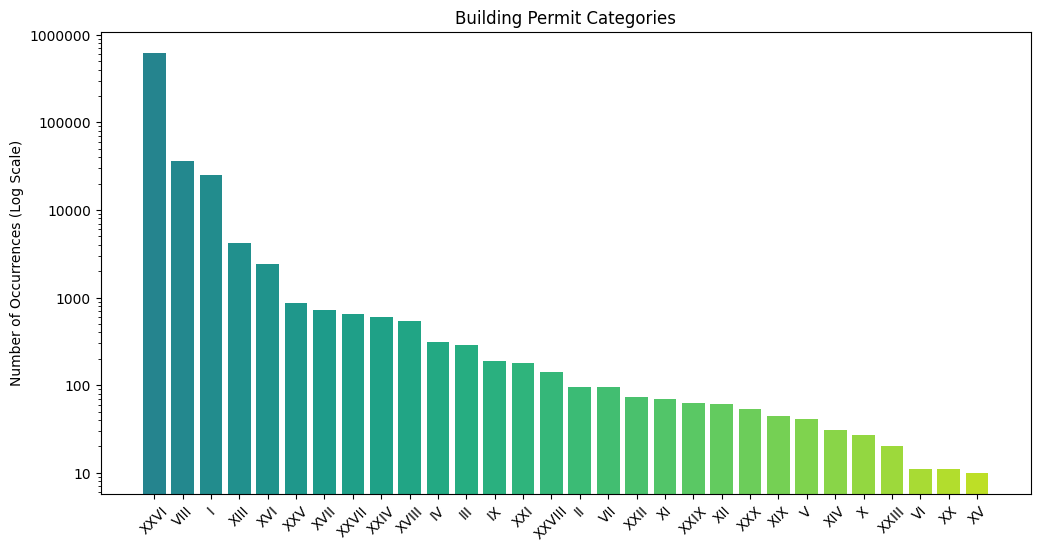

In [5]:
def categories_counter_log(df):
    counter = Counter()
    
    for record in df['kategoria']:
        counter[record] += 1

    # Sorting the data
    sorted_data = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))

    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Create color gradient for the plot
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    # Plot details
    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=45)
    plt.ylabel('Number of Occurrences (Log Scale)')
    plt.title('Building Permit Categories')
    
    # Set Y-axis to logarithmic scale
    plt.yscale('log')

    # Format Y-axis labels as actual numbers instead of powers of 10
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y)))

categories_counter_log(df)


### Names of construction intention type

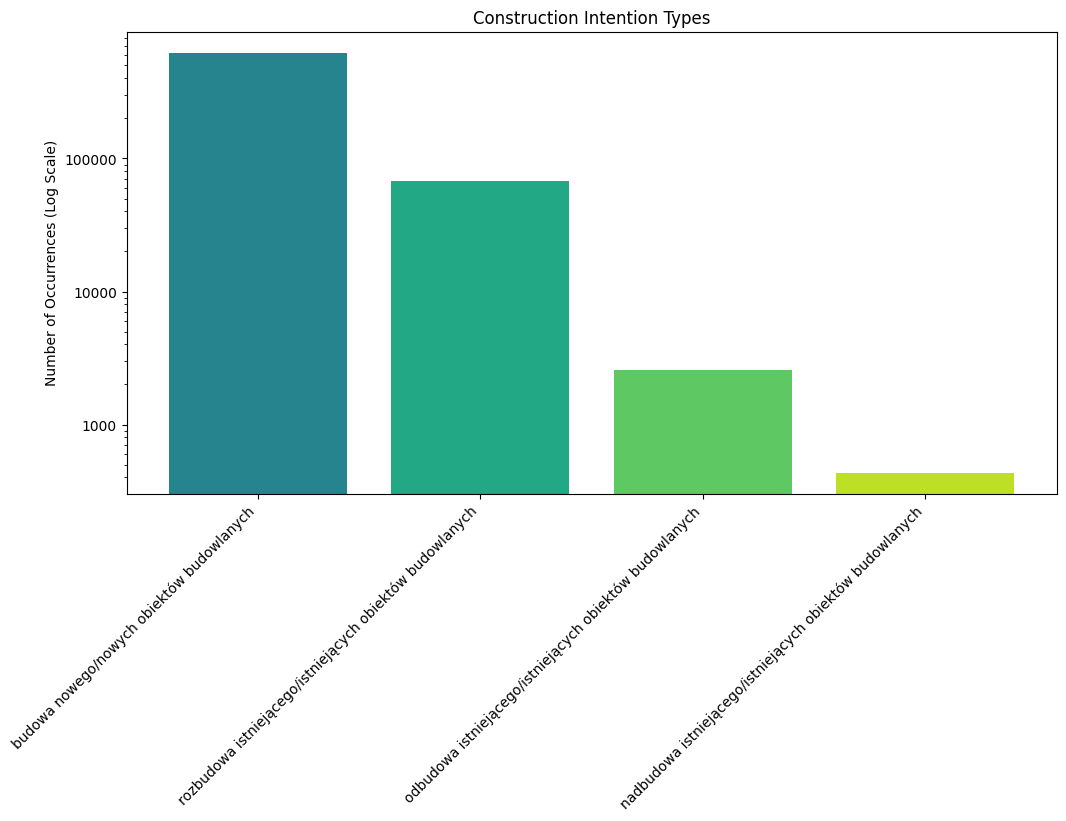

In [6]:
def construction_intention_counter_log(df, column_name):
    counter = Counter()
    
    for record in df[column_name]:
        counter[record] += 1
        
    sorted_data = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Adjust np.linspace to match the number of categories in sorted_data
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=45, ha='right')  
    plt.ylabel('Number of Occurrences (Log Scale)')
    plt.title('Construction Intention Types')
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y)))

    plt.show()

construction_intention_counter_log(df, 'rodzaj_zam_budowlanego')


### Date of receipt of the build application (by month)

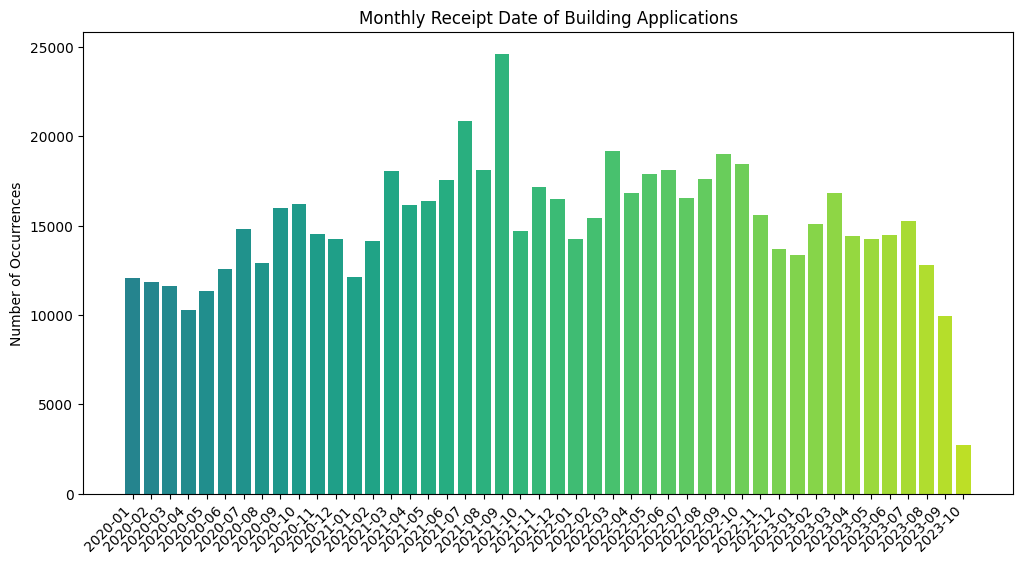

In [7]:
def monthly_receipt_date_counter(df, column_name):
    # Convert column to datetime
    df[column_name] = pd.to_datetime(df[column_name])

    # Group by year and month
    df['YearMonth'] = df[column_name].dt.to_period('M')

    # Count occurrences by month
    counter = Counter(df['YearMonth'])

    # Sort data by date (YearMonth) instead of occurrences
    sorted_data = dict(sorted(counter.items()))

    # Create the plot
    plt.figure(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    # Convert PeriodIndex to string for plotting
    sorted_keys = [str(key) for key in sorted_data.keys()]
    plt.bar(sorted_keys, sorted_data.values(), color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Occurrences')
    plt.title('Monthly Receipt Date of Building Applications')

    plt.show()

monthly_receipt_date_counter(df, 'data_wplywu_wniosku_do_urzedu')

### Teritorial units downloading

In [ ]:
url = 'https://www.gis-support.pl/downloads/2022/powiaty.zip'
local_zip_path = 'zip_data.zip'
extract_to_folder = 'unpacked_zip_data_files'
shapefile_path = 'unpacked_zip_data_files/powiaty.shp'

def download_and_unpack_zip(url, local_zip_path, extract_to_folder):
    # Start downloading the ZIP file
    print("Starting to download the ZIP file...")
    response = requests.get(url)
    
    # Save the downloaded ZIP file locally
    with open(local_zip_path, 'wb') as file:
        file.write(response.content)
    
    # ZIP file downloaded, start extracting it
    print("ZIP file downloaded. Starting the extraction...")
    
    # Check if the extract_to_folder already exists
    if os.path.exists(extract_to_folder):
        print(f"Removing existing folder: {extract_to_folder}")
        shutil.rmtree(extract_to_folder)
    
    # Create the folder before extraction
    os.makedirs(extract_to_folder)
    
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_folder)
    
    # Extraction completed
    print("Extraction finished.")
    
    # Remove the downloaded ZIP file from the working directory
    os.remove(local_zip_path)

download_and_unpack_zip(url, local_zip_path, extract_to_folder)

gdf = gpd.read_file(shapefile_path)

### Applying voivodships and powiats' names to records of build permits data

In [21]:
# Dictionary with mappings of voivodeship codes to voivodeship names
voivodeships = {
    '02': 'Lower Silesian',
    '04': 'Kuyavian-Pomeranian',
    '06': 'Lublin',
    '08': 'Lubusz',
    '10': 'Lodz',
    '12': 'Lower Poland',
    '14': 'Masovian',
    '16': 'Opole',
    '18': 'Podkarpackie',
    '20': 'Podlaskie',
    '22': 'Pomeranian',
    '24': 'Silesian',
    '26': 'Swietokrzyskie',
    '28': 'Warmian-Masurian',
    '30': 'Greater Poland',
    '32': 'West Pomeranian',
}

#Temporary iterator
temp_iter = 0

# Function for assigning voivodeship names based on TERYT code
def terc_to_voivodeship(terc_code):
    voivodeship_code = terc_code[:2]
    
    # Check if the voivodeship code exists in the dictionary
    if voivodeship_code in voivodeships:
        voivodeship = voivodeships[voivodeship_code]
    else:
        voivodeship = 'Unknown'
    
    return voivodeship

# Create a mapping of powiat codes to powiat names from DataFrame gdf
powiat_mapping = gdf.set_index('JPT_KOD_JE')['JPT_NAZWA_'].to_dict()
powiat_mapping = {key[2:]: value for key, value in powiat_mapping.items()}

# Function for assigning powiat names based on TERYT code
def terc_to_powiat(terc_code):
    powiat_code = terc_code[2:4]
    
    # Use the pre-created powiat_mapping to get the powiat name
    powiat = powiat_mapping.get(powiat_code, 'Unknown')
    
    return powiat

for powiat_code, powiat_name in powiat_mapping.items():
    print(f'Powiat code: {powiat_code}, Powiat name: {powiat_name}')


# Creating columns in DataFrame df with voivodeship and powiat names
df['voivodeship'] = df['terc'].apply(terc_to_voivodeship)
df['powiat'] = df['terc'].apply(terc_to_powiat)

Powiat code: 07, Powiat name: powiat sulęciński
Powiat code: 04, Powiat name: powiat grajewski
Powiat code: 15, Powiat name: powiat szczecinecki
Powiat code: 13, Powiat name: powiat rawski
Powiat code: 19, Powiat name: powiat wielicki
Powiat code: 08, Powiat name: powiat miechowski
Powiat code: 11, Powiat name: powiat nidzicki
Powiat code: 21, Powiat name: powiat wałbrzyski
Powiat code: 28, Powiat name: powiat wągrowiecki
Powiat code: 32, Powiat name: powiat warszawski zachodni
Powiat code: 12, Powiat name: powiat nowomiejski
Powiat code: 61, Powiat name: powiat Ostrołęka
Powiat code: 02, Powiat name: powiat braniewski
Powiat code: 09, Powiat name: powiat lipski
Powiat code: 06, Powiat name: powiat namysłowski
Powiat code: 17, Powiat name: powiat szczycieński
Powiat code: 10, Powiat name: powiat łęczyński
Powiat code: 62, Powiat name: powiat Płock
Powiat code: 63, Powiat name: powiat Chorzów
Powiat code: 03, Powiat name: powiat chrzanowski
Powiat code: 74, Powiat name: powiat Siemianow

,id,numer_ewidencyjny_system,numer_ewidencyjny_urzad,data_wplywu_wniosku_do_urzedu,nazwa_organu,wojewodztwo_objekt,obiekt_kod_pocztowy,miasto,terc,cecha,cecha2,ulica,ulica_dalej,nr_domu,kategoria,nazwa_zam_budowlanego,rodzaj_zam_budowlanego,kubatura,stan,jednostki_numer,obreb_numer,numer_dzialki,numer_arkusza_dzialki,nazwisko_projektanta,imie_projektanta,projektant_numer_uprawnien,projektant_pozostali,YearMonth,voivodeship,powiat
0,1,ST-SL-BI/ZGŁOSZENIE/1432/2020,Wb.6743.3.107.2020.KaM,2020-06-04,Starosta Powiatu Bielsko-Biała,śląskie,43-518,Ligota,2402045,,,,,,XVI,Rozbudowa sieci gazowej wraz z przyłączem,rozbudowa istniejącego/istniejących obiektów b...,,Brak sprzeciwu,240204_5,0005,2395/8,,Świder,Katarzyna,SLK/4131/PWOS/12,,2020-06,Silesian,powiat braniewski
1,2,ST-SL-BI/ZGŁOSZENIE/1432/2020,Wb.6743.3.107.2020.KaM,2020-06-04,Starosta Powiatu Bielsko-Biała,śląskie,43-518,Ligota,2402045,,,,,,XVI,Rozbudowa sieci gazowej wraz z przyłączem,rozbudowa istniejącego/istniejących obiektów b...,,Brak sprzeciwu,240204_5,0005,2395/5,,Świder,Katarzyna,SLK/4131/PWOS/12,,2020-06,Silesian,powiat braniewski
2,3,ST-SL-RB/ZGŁOSZENIE/6774/2021,AB.6743.915.2021,2021-11-26,Starosta Powiatu Rybnik,śląskie,44-238,Przegędza,2412015,ul.,ul.,Dworcowa,,,XXVI,Budowa sieci gazowej średniego ciśnienia D40 P...,budowa nowego/nowych obiektów budowlanych,,Brak sprzeciwu,241201_5,0004,1389/6,,Towarek,Grzegorz,SLK/2409/ZOOS/08,,2021-11,Silesian,powiat nowomiejski
3,4,ST-SL-RB/ZGŁOSZENIE/6774/2021,AB.6743.915.2021,2021-11-26,Starosta Powiatu Rybnik,śląskie,44-238,Przegędza,2412015,ul.,ul.,Dworcowa,,,XXVI,Budowa sieci gazowej średniego ciśnienia D40 P...,budowa nowego/nowych obiektów budowlanych,,Brak sprzeciwu,241201_5,0004,1727/10,,Towarek,Grzegorz,SLK/2409/ZOOS/08,,2021-11,Silesian,powiat nowomiejski
4,5,ST-SL-RB/ZGŁOSZENIE/6774/2021,AB.6743.915.2021,2021-11-26,Starosta Powiatu Rybnik,śląskie,44-238,Przegędza,2412015,ul.,ul.,Dworcowa,,,XXVI,Budowa sieci gazowej średniego ciśnienia D40 P...,budowa nowego/nowych obiektów budowlanych,,Brak sprzeciwu,241201_5,0004,1850/10,,Towarek,Grzegorz,SLK/2409/ZOOS/08,,2021-11,Silesian,powiat nowomiejski
5,6,ST-SW-OS/ZGŁOSZENIE/257/2020,AB.6743.1.41.2020,2020-04-10,Starosta Powiatu Ostrowiec Świętokrzyski,świętokrzyskie,,Kolonia Piaski,2607055,,,,,,XXVI,budowa gazociągu średniego cisnienia PE dn 63 ...,budowa nowego/nowych obiektów budowlanych,,Brak sprzeciwu,260705_5,0001,3/2,,Cieśla,Kamil,SWK/0146/PWOS/11,,2020-04,Swietokrzyskie,powiat sulęciński
6,7,ST-SW-OS/ZGŁOSZENIE/257/2020,AB.6743.1.41.2020,2020-04-10,Starosta Powiatu Ostrowiec Świętokrzyski,świętokrzyskie,,Kolonia Piaski,2607055,,,,,,XXVI,budowa gazociągu średniego cisnienia PE dn 63 ...,budowa nowego/nowych obiektów budowlanych,,Brak sprzeciwu,260705_5,0001,110/3,,Cieśla,Kamil,SWK/0146/PWOS/11,,2020-04,Swietokrzyskie,powiat sulęciński
7,8,ST-MA-NT/ZGŁOSZENIE/1810/2020,080/2020/BA.6743.1.84.2020,2020-05-11,Starosta Powiatu Nowy Targ,małopolskie,34-713,Skawa,1211112,,,,,,XXVI,budowa sieci gazowej średniego ciśnienia wraz ...,budowa nowego/nowych obiektów budowlanych,,Brak sprzeciwu,121111_2,0008,5885/47,,Knap,Grzegorz,MAP/0323/PWOS/07,,2020-05,Lower Poland,powiat nidzicki
8,9,ST-MA-NT/ZGŁOSZENIE/1810/2020,080/2020/BA.6743.1.84.2020,2020-05-11,Starosta Powiatu Nowy Targ,małopolskie,34-713,Skawa,1211112,,,,,,XXVI,budowa sieci gazowej średniego ciśnienia wraz ...,budowa nowego/nowych obiektów budowlanych,,Brak sprzeciwu,121111_2,0008,5882/3,,Knap,Grzegorz,MAP/0323/PWOS/07,,2020-05,Lower Poland,powiat nidzicki
9,10,ST-MA-NT/ZGŁOSZENIE/1810/2020,080/2020/BA.6743.1.84.2020,2020-05-11,Starosta Powiatu Nowy Targ,małopolskie,34-713,Skawa,1211112,,,,,,XXVI,budowa sieci gazowej średniego ciśnienia wraz ...,budowa nowego/nowych obiektów budowlanych,,Brak sprzeciwu,121111_2,0008,5881/1,,Knap,Grzegorz,MAP/0323/PWOS/07,,2020-05,Lower Poland,powiat nidzicki


### Displaying a sample of downloaded teritorial units data

In [17]:
pd.set_option('display.max_columns', None)
gdf.head()

,gml_id,JPT_SJR_KO,JPT_POWIER,JPT_KOD_JE,JPT_NAZWA_,JPT_ORGAN_,JPT_JOR_ID,WERSJA_OD,WERSJA_DO,WAZNY_OD,WAZNY_DO,JPT_KOD__1,JPT_NAZWA1,JPT_ORGAN1,JPT_WAZNA_,ID_BUFORA_,ID_BUFORA1,ID_TECHNIC,IIP_PRZEST,IIP_IDENTY,IIP_WERSJA,JPT_KJ_IIP,JPT_KJ_I_1,JPT_KJ_I_2,JPT_OPIS,JPT_SPS_KO,ID_BUFOR_1,JPT_ID,JPT_POWI_1,JPT_KJ_I_3,JPT_GEOMET,JPT_GEOM_1,SHAPE_LENG,SHAPE_AREA,REGON,RODZAJ,geometry
0,None,POW,92617,1807,powiat krośnieński,None,13415,20210128,0,20170101,0,None,None,NZN,BRK,201859,0,1331302,PL.PZGIK.200,798ef296-2055-4890-993f-d414c67164ab,2021-01-28T13:43:40+01:00,EGIB,1807,None,None,UZG,0,1359583,0,None,0,0,3.11205337354,.12332626559,37044051900000,powiat,"POLYGON ((689863.285 218885.536, 689862.128 21..."
1,None,POW,141297,2804,powiat elbląski,None,13422,20210514,0,20120926,0,None,None,NZN,NZN,218263,0,829271,PL.PZGIK.200,61a0d267-58aa-4f3a-86e7-faa281e50ebc,2021-05-14T13:19:46+02:00,EGIB,2804,None,None,UZG,0,1360107,0,None,0,0,4.2521309989,.19417975633,17074769000000,powiat,"POLYGON ((551842.165 693417.652, 551870.912 69..."
2,None,POW,209827,1415,powiat ostrołęcki,None,13409,20210518,0,20120926,0,None,None,NZN,NZN,219096,0,829100,PL.PZGIK.200,d2f96418-0366-4f59-8793-fef1aa0ca19f,2021-05-18T08:56:02+02:00,EGIB,1415,None,None,UZG,0,1360143,0,None,0,0,5.31641009622,.28125317026,55066883500000,powiat,"POLYGON ((646230.458 617154.258, 646336.602 61..."
3,None,POW,79097,0413,powiat sępoleński,None,13424,20220112,0,20120926,0,None,None,NZN,NZN,253504,0,829353,PL.PZGIK.200,09447bc4-a3c3-4d84-83ab-d61a69820974,2022-01-12T10:03:23+01:00,EGIB,0413,None,None,UZG,0,1362180,0,None,0,0,2.00313300009,.10690160786,09235092600000,powiat,"POLYGON ((384997.245 615178.269, 385170.687 61..."
4,None,POW,126576,3019,powiat pilski,None,13417,20220112,0,20120926,0,None,None,NZN,NZN,253504,0,829157,PL.PZGIK.200,196c6cd5-4f8d-4e98-a653-e0a36ccac728,2022-01-12T10:03:23+01:00,EGIB,3019,None,None,UZG,0,1362184,0,None,0,0,4.17134504707,.17008216429,57079948000000,powiat,"POLYGON ((342585.530 579834.380, 342632.859 57..."


In [22]:
pd.set_option('display.max_columns', None)  # Ustawienie opcji wyświetlania wszystkich kolumn
pd.set_option('display.max_rows', None)  # Ustawienie opcji wyświetlania wszystkich wierszy

# Wyświetl GeoDataFrame
print(gdf)

    gml_id JPT_SJR_KO JPT_POWIER JPT_KOD_JE                      JPT_NAZWA_  \
0     None        POW      92617       1807              powiat krośnieński   
1     None        POW     141297       2804                 powiat elbląski   
2     None        POW     209827       1415               powiat ostrołęcki   
3     None        POW      79097       0413               powiat sępoleński   
4     None        POW     126576       3019                   powiat pilski   
5     None        POW      72529       3208              powiat kołobrzeski   
6     None        POW      72186       3011               powiat kościański   
7     None        POW     189985       3021                powiat poznański   
8     None        POW     101693       0408                powiat lipnowski   
9     None        POW      73528       1428             powiat sochaczewski   
10    None        POW      53319       1432      powiat warszawski zachodni   
11    None        POW     126991       0604         